# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
display(df.head())
df.info()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [6]:
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def prepair_balance(balance):
    balance = str(balance)
    balance = balance.replace(',', '.').replace('$', '').replace(' ', '')
    return float(balance.strip())

df['balance'] = df['balance'].apply(prepair_balance)
df['balance'].mean().round(3)

1529.129

### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())

In [9]:
df['balance'].mean().round(3)

1526.936

### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
job_replacement = df['job'].mode().iloc[0]
education_replacement = df['education'].mode().iloc[0]

In [11]:
df['job'] = df['job'].apply(lambda x: job_replacement if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: education_replacement if x == 'unknown' else x)

In [12]:
mask1 = df['job'] == job_replacement
mask2 = df['education'] == education_replacement
df[mask1 & mask2]['balance'].mean().round(3)

1598.883

### Задание 6

In [13]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return lower_bound, upper_bound, outliers, cleaned

lower_bound, upper_bound, outliers, cleaned_df = outliers_iqr(df, 'balance')
print(f'Верхняя граница: {round(upper_bound)}, нижняя граница: {round(lower_bound)}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned_df.shape[0]}')

Верхняя граница: 4063, нижняя граница: -2241
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64

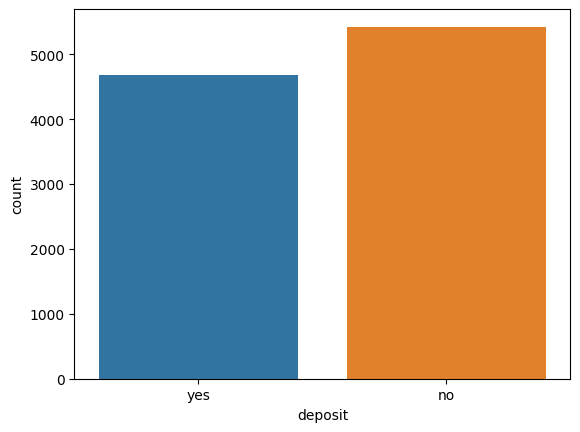

In [14]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
sns.countplot(cleaned_df, x='deposit')
display(cleaned_df['deposit'].value_counts())

### Задания 2 и 3

In [15]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
cleaned_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [16]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
cleaned_df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [17]:
numerical_columns = [col for col in cleaned_df.columns if cleaned_df[col].dtype != 'object']
categorical_columns = [col for col in cleaned_df.columns if col not in numerical_columns]
print(numerical_columns, categorical_columns, sep='\n')

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


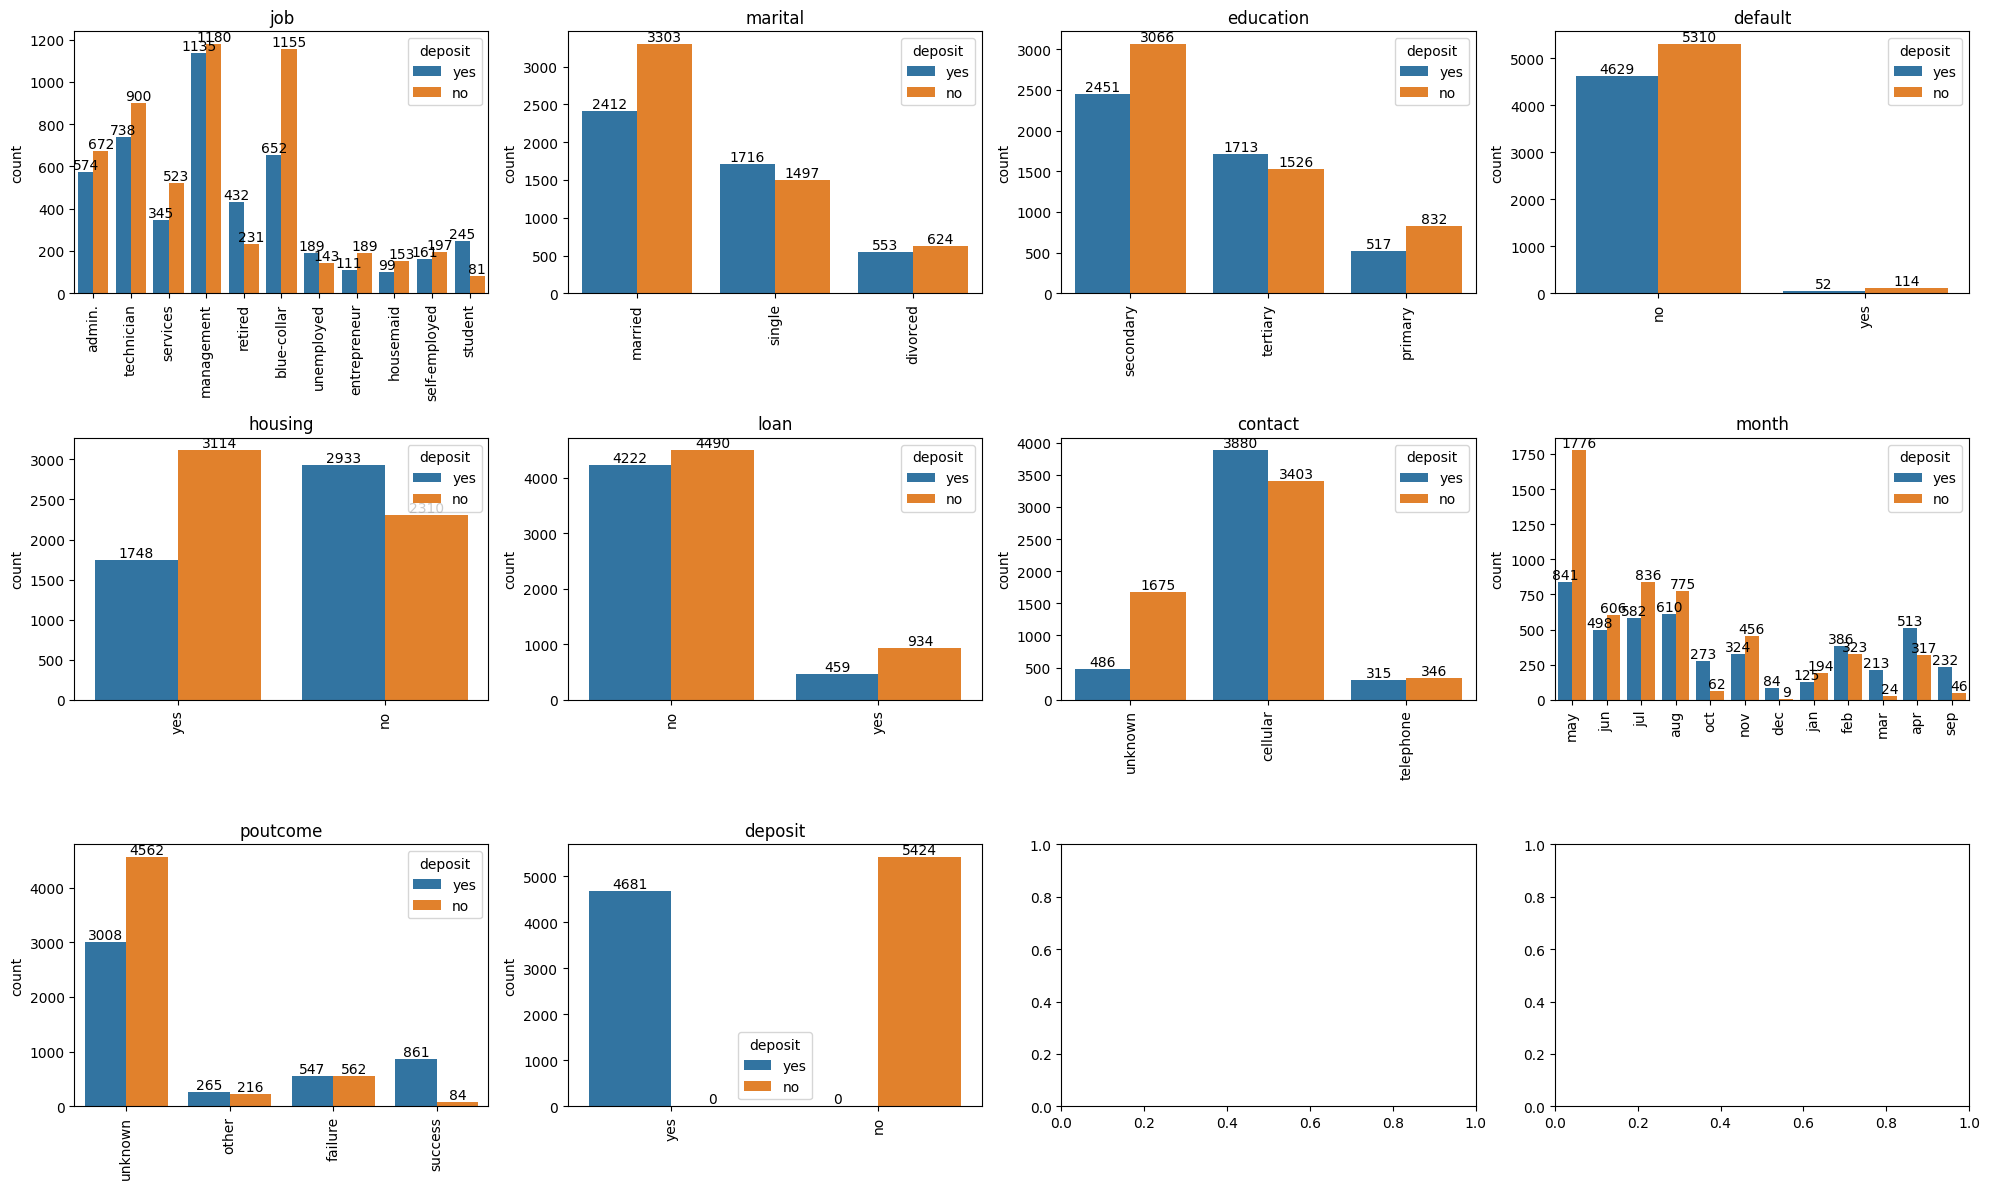

In [18]:
n = len(categorical_columns)
cols = 4
rows = int(np.ceil(n / 4))
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
row_counter = 0
col_counter = 0
for future in categorical_columns:
    if col_counter < cols:
        countplot = sns.countplot(cleaned_df, x=future, hue='deposit', ax=axes[row_counter][col_counter])
        countplot.set_title(future)
        countplot.xaxis.set_tick_params(rotation=90)
        countplot.set_xlabel('')
        for label in countplot.containers:
            countplot.bar_label(label)
        col_counter += 1
    else:
        row_counter += 1
        col_counter = 0
        countplot = sns.countplot(cleaned_df, x=future, hue='deposit', ax=axes[row_counter][col_counter])
        countplot.set_title(future)
        countplot.xaxis.set_tick_params(rotation=90)
        countplot.set_xlabel('')
        for label in countplot.containers:
            countplot.bar_label(label)
        col_counter += 1
plt.tight_layout()

### Задание 6

<Axes: xlabel='poutcome'>

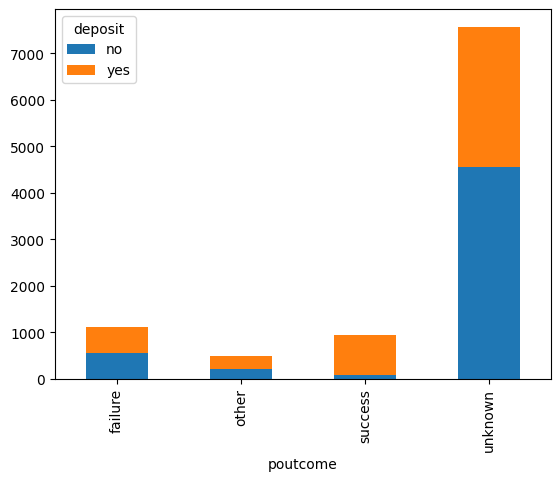

In [19]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
cleaned_df.groupby(['poutcome'])['deposit'].value_counts().unstack().plot(kind='bar', stacked=True)

### Задание 7

<Axes: xlabel='month'>

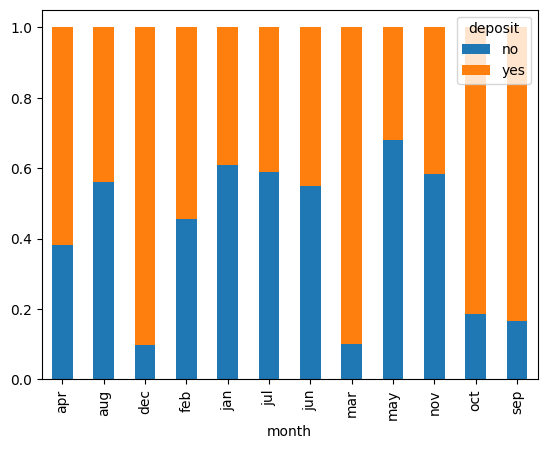

In [20]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
cleaned_df.groupby('month')['deposit'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

### Задание 8

In [21]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned_df['age group'] = cleaned_df['age'].apply(lambda x: ['<30','30-40', '40-50', '50-60', '60+'][(x > 30) + (x >= 40) + (x >= 50) + (x >= 60)])

<Axes: xlabel='age group', ylabel='count'>

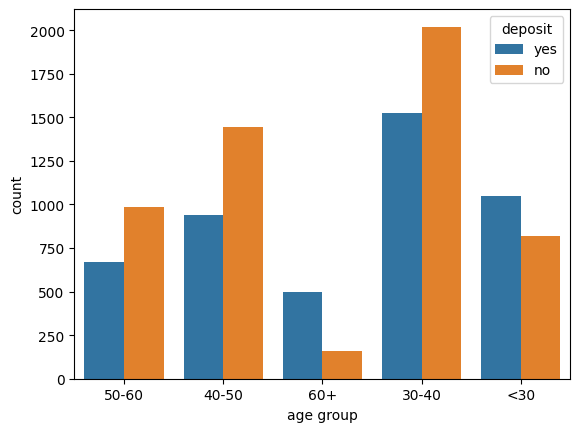

In [22]:
sns.countplot(cleaned_df, x='age group', hue='deposit')

<Axes: xlabel='age group'>

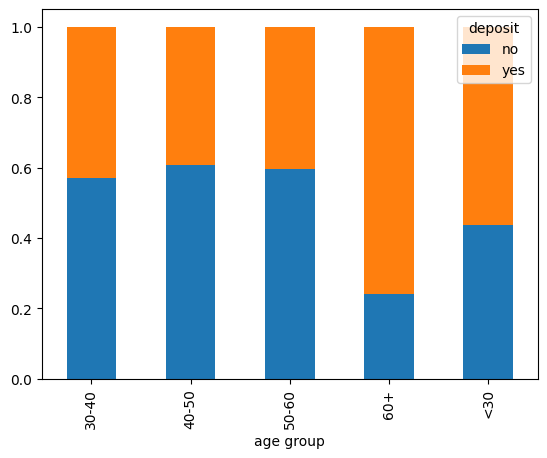

In [23]:
cleaned_df.groupby(['age group'])['deposit'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

### Задания 9 и 10

<Axes: xlabel='deposit', ylabel='count'>

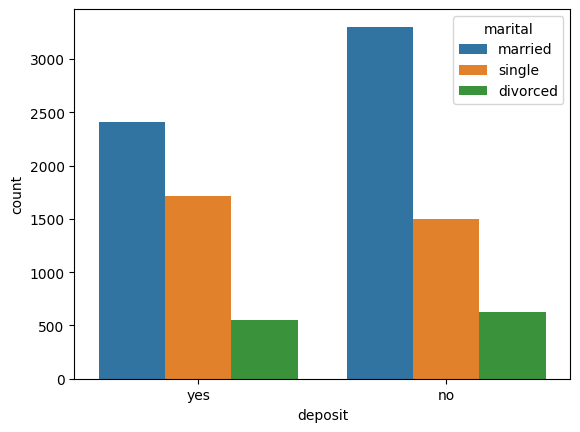

In [24]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(cleaned_df, x='deposit', hue='marital')

<Axes: xlabel='deposit', ylabel='count'>

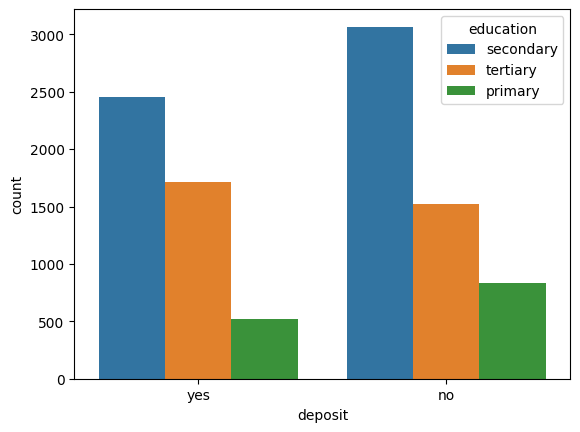

In [25]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(cleaned_df, x='deposit', hue='education')

<Axes: xlabel='deposit', ylabel='count'>

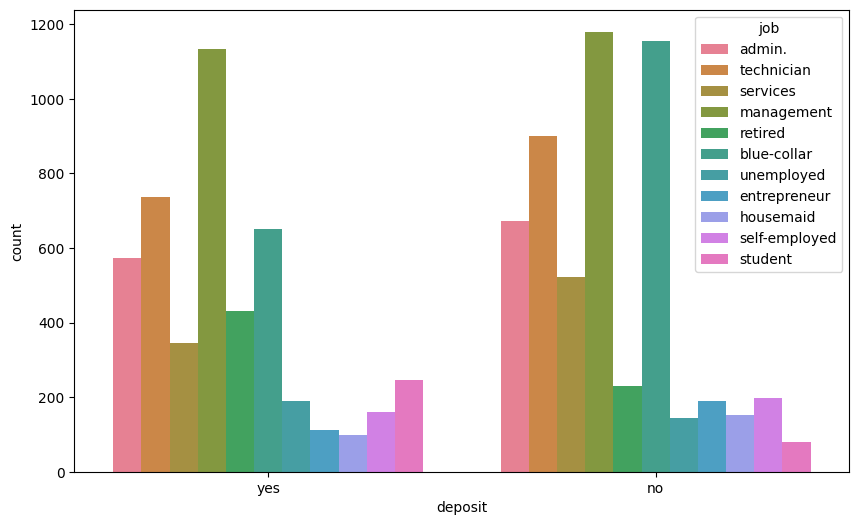

In [26]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = plt.subplots(figsize=(10, 6))
sns.countplot(cleaned_df, x='deposit', hue='job', palette='husl')

### Задание 11

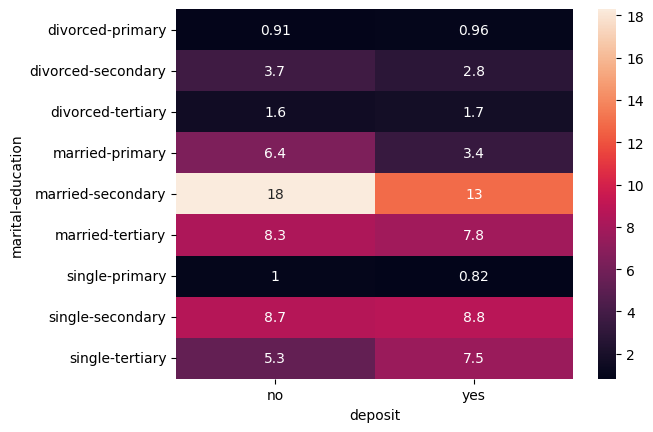

In [45]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
sns.heatmap(pd.crosstab([cleaned_df['marital'], cleaned_df['education']], cleaned_df['deposit']) / 100, annot=True);

## Часть 3: преобразование данных

### Задание 1

In [28]:
# преобразуйте уровни образования

### Задания 2 и 3

In [29]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [30]:
# создайте дамми-переменные

### Задания 5 и 6

In [31]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [32]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [33]:
# рассчитайте необходимые показатели

### Задание 9

In [34]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [35]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [36]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [37]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [38]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [39]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [40]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [41]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [42]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [43]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna